# CycleGAN Challenge

Tyler Beisel

DTSA 5511 - CU Boulder

Summer 1

## The Challenge

The goal of this kaggle competition is to create a generative adversarial network that can turn pictures into Monet style paintings. Understanding and advancings GANs is an important step in the future of AI, as GANs are crucial for AI to be "creative". 

Specifically, for this challenge you must create 7,000 - 10,000 Monet style images that can be submitted.

Next we will look at some EDA and some basics with the Data. 

## Set-up and Exploratory Data Analysis

### Data background
We can see from the competition page that 300 monet style paintings are provided and 7028 normal photos are provided. These can be used to train the GAN, and then the same images can be used for the competition submission. 

Additionally, both jpegs and TFRecords are provided. I am much more familiar with jpegs, but this is a good opportunity to learn how to use TFRecords so I will be using TFRecords throughout this notebook.

In [1]:
# Load in the necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Next, we will load in th TFRecords files for the two datasets.

In [2]:
monet_filenames = [
    '/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec',
    '/kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec',
    '/kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec',
    '/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec',
    '/kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec'
]

photo_filenames = [
    '/kaggle/input/gan-getting-started/photo_tfrec/photo00-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo01-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo02-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo03-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo04-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo07-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo09-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo10-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo13-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo14-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo15-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo16-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec',
    '/kaggle/input/gan-getting-started/photo_tfrec/photo19-350.tfrec'
]

These functions below will help us process the TFRecords Dataset.

In [3]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[256,256], 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [4]:
monet_dataset = load_dataset(monet_filenames).batch(1)
photo_dataset = load_dataset(photo_filenames).batch(1)

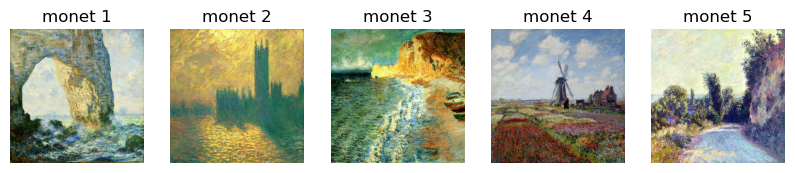

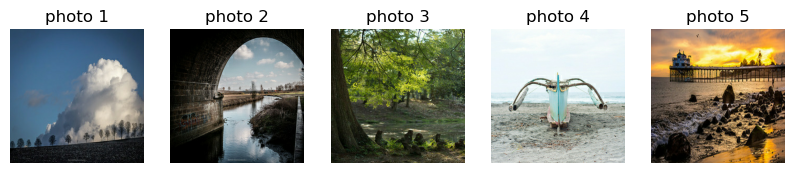

In [5]:
# Plot monet photos
plt.figure(figsize=(10, 10))
for i, img in enumerate(monet_dataset.take(5)):
    plt.subplot(1, 5, i+1)
    plt.title(f'monet {i+1}')
    plt.imshow(img[0] * 0.5 + 0.5)
    plt.axis('off')  
plt.show()

#plot regular images
plt.figure(figsize=(10, 10))
for i, img in enumerate(photo_dataset.take(5)):
    plt.subplot(1, 5, i+1)
    plt.title(f'photo {i+1}')
    plt.imshow(img[0] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

As you can see, the monet paintings have a very distinct style. They appear to have very wide brushstrokes, which is a stark contrast compared to the high resolution images in the regular images dataset. 

In [6]:
num_monet_samples = len(list(monet_dataset))
num_photo_samples = len(list(photo_dataset))

monet_shape = next(iter(monet_dataset)).shape
photo_shape = next(iter(photo_dataset)).shape

print(num_monet_samples)
print(num_photo_samples)
print(monet_shape)
print(photo_shape)

300
7038
(1, 256, 256, 3)
(1, 256, 256, 3)


This confirms that our datasets are the size that we expect. Additionally, each image is 256x256x3. This is useful info to know as we move on to building the model itself. 

## Model Experimentation

For this challenge, I will be using a Cycle-GAN to attempt to turn the regular photos into monet style paintings. Cycle-GANs are very useful for trying to change images from one style into a different style, which is the exact goal of this challenge. Similar to regular GANs, Cycle GANs consist of a generator and discriminator, and each side is trying to trick the other. The generator is attempting to turn the regular images into monet style images and the discriminator is attempting to classify the real and fake images. 

More about CycleGANs can be found here https://keras.io/examples/generative/cyclegan/ and https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7. These resources were invaluable as CycleGANs were not covered in this class. 

For this project, I will experiment with two CycleGANs. The first CycleGAN will have a simpler generator and discriminator while the second will have deeper components. At the end, we will be able to compare which model performed best. 

### Reference
As recommended in the kaggle competition overview, I used the example notebook found here https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook as a starting point. Since building a complete cycle gan from the ground up is outside of the scope of this class and project, different pieces of the cyclegan were adapted from the tutorial. However, to make sure that my submission is original, I have designed my own discriminators and generators since that was the goal of this Deep Learning course. This also forced me to truly understand the other pieces, since my generator and discriminator needed to fit with the all of the functions needed for the CycleGAN. 

### Downsample and Upsample Layers
First, we add functions to create downsample and upsample layers. These functions were adapted from the tutorial, however, the leaky ReLU activation functions were changed to ReLU. 

In [7]:
# Changed leaky ReLU to ReLU

def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.ReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Generator
Next, we build the generator. This is our first pass and will be a simpler generator then the second attempt. We only have 4 downsample and 4 upsample layers in this version. 

In [8]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(128, 4, apply_instancenorm=False, strides=4), # (bs, 64, 64, 128)
        downsample(256, 4, strides=4), # (bs, 16, 16, 256)
        downsample(512, 4, strides=4), # (bs, 4, 4, 512)
        downsample(512, 4, strides=4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, strides=4), # (bs, 4, 4, 512)
        upsample(256, 4, strides=4), # (bs, 16, 16, 256)
        upsample(256, 4, strides=4), # (bs, 64, 64, 256)
        upsample(128, 4, strides=2), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=4,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

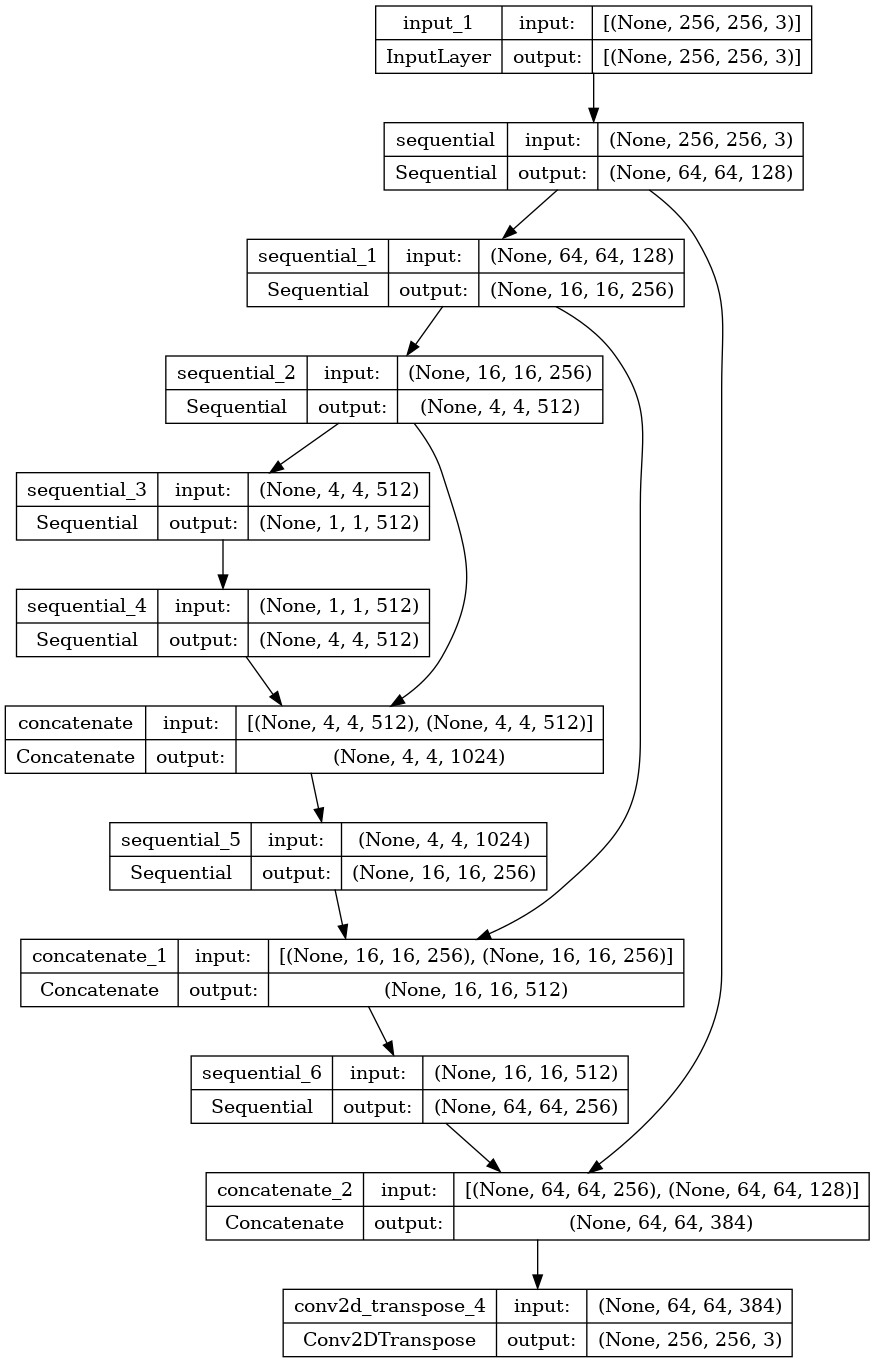

In [9]:
model = Generator()
keras.utils.plot_model(model, show_shapes=True)

### Discriminator
Next, we build the discriminator. Once again, we will start with a simple discriminator. This version only has 2 initial downsample layers. 

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4)(x) # (bs, 128, 128, 64)
    down2 = downsample(256, 8, strides=4)(down1) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down2) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

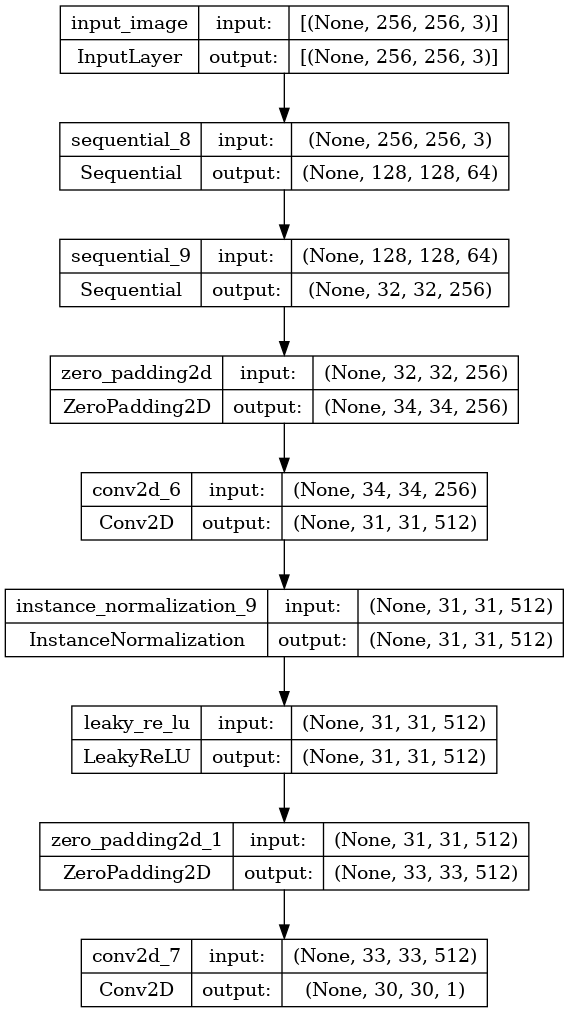

In [11]:
model = Discriminator()
keras.utils.plot_model(model, show_shapes=True)

### CycleGAN model infrastructure
This next section is largely adapted from the tutorial. This section is what builds the CycleGAN architecture. Building this from scratch was outside of the scope of this project, so I focused on experimenting with custom generators and discriminators. 

In [12]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [15]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [17]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [34]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

### Model Training

We are now ready to train our CycleGAN. We will train for 25 epochs

In [36]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 61s 104ms/step - monet_gen_loss: 6.7166 - photo_gen_loss: 6.9194 - monet_disc_loss: 0.4727 - photo_disc_loss: 0.4644
Epoch 2/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 5.7571 - photo_gen_loss: 6.1022 - monet_disc_loss: 0.4680 - photo_disc_loss: 0.3413
Epoch 3/25
300/300 [==============================] - 31s 105ms/step - monet_gen_loss: 5.7583 - photo_gen_loss: 5.9681 - monet_disc_loss: 0.3947 - photo_disc_loss: 0.3469
Epoch 4/25
300/300 [==============================] - 31s 105ms/step - monet_gen_loss: 5.3179 - photo_gen_loss: 5.7517 - monet_disc_loss: 0.4484 - photo_disc_loss: 0.3276
Epoch 5/25
300/300 [==============================] - 31s 105ms/step - monet_gen_loss: 5.2976 - photo_gen_loss: 5.7624 - monet_disc_loss: 0.4584 - photo_disc_loss: 0.3407
Epoch 6/25
300/300 [==============================] - 31s 105ms/step - monet_gen_loss: 5.2932 - photo_gen_loss: 5.7075 - monet_disc_loss: 0.4785 

Now that the model is done training, we can plot some of our monet style conversions to see how well it did!

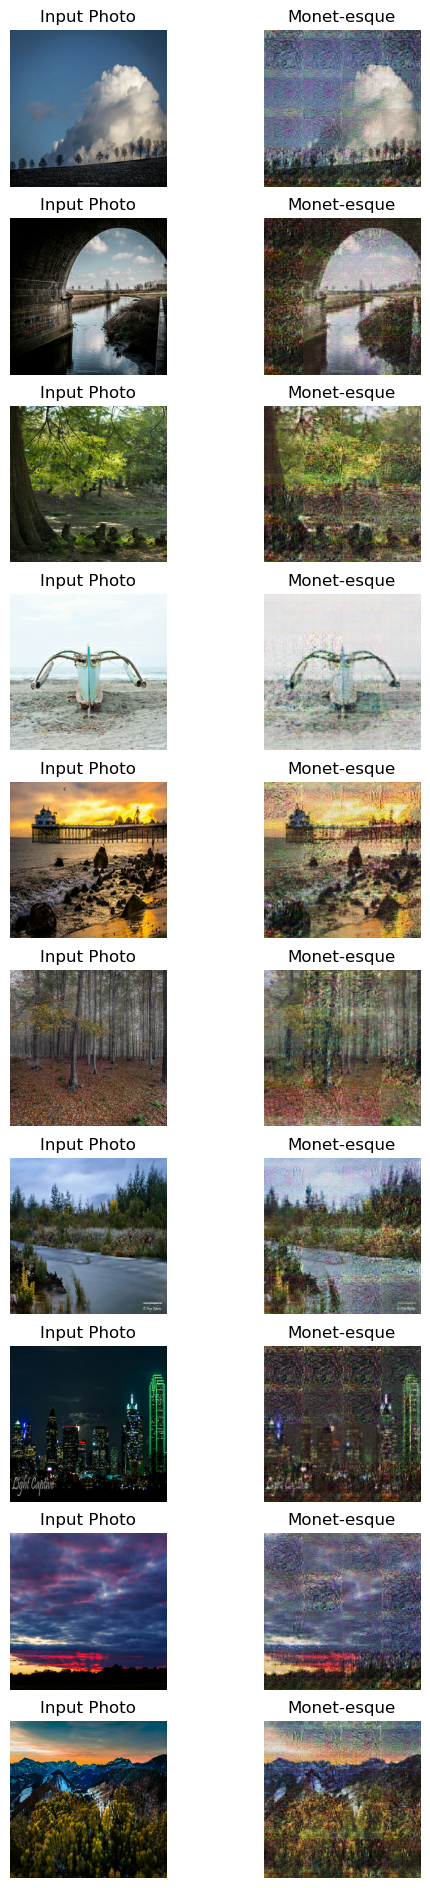

In [40]:
_, ax = plt.subplots(10, 2, figsize=(6, 24))
for i, img in enumerate(photo_dataset.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

As you can see, our model successfully creates images that look somewhat monet like. The predictions are not perfect. They look more grainy as opposed to wide brush strokes, but there is a reason painting with wide brushstrokes is so difficult. All in all, our model performs decently. We can now submit the model to see how it does on the kaggle leaderboard. 

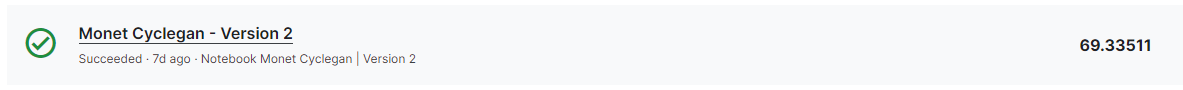

Our submission got a score of 69.33. This is not bad but definitely leaves a lot of room to improve. Next, we will turn to using a more complicated generator and discriminator.

## Bigger Generator and Discriminator

Now, we will try training a model with a larger discriminator and generator and see how that affects the performance of the model. 

### Bigger Generator
This larger generator has 8 downsample and 7 upsample layers, as opposed to the 4 layers in the simpler model. 

In [18]:
def BiggerGenerator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(32, 4, apply_instancenorm=False, strides=2), # (bs, 128, 128, 32)
        downsample(64, 4, strides=2), # (bs, 64, 64, 64)
        downsample(128, 4, strides=2), # (bs, 32, 32, 128)
        downsample(256, 4, strides=2), # (bs, 16, 16, 256)
        downsample(512, 4, strides=2), # (bs, 8, 8, 512)
        downsample(512, 4, strides=2), # (bs, 4, 4, 512)
        downsample(512, 4, strides=2), # (bs, 2, 2, 512)
        downsample(512, 4, strides=2), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, strides=2), # (bs, 2, 2, 512)
        upsample(512, 4, strides=2), # (bs, 4, 4, 512)
        upsample(256, 4, strides=2), # (bs, 8, 8, 256)
        upsample(256, 4, strides=2), # (bs, 16, 16, 512)
        upsample(128, 4, strides=2), # (bs, 32, 32, 128)
        upsample(128, 4, strides=2), # (bs, 64, 64, 128)
        upsample(128, 4, strides=2), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

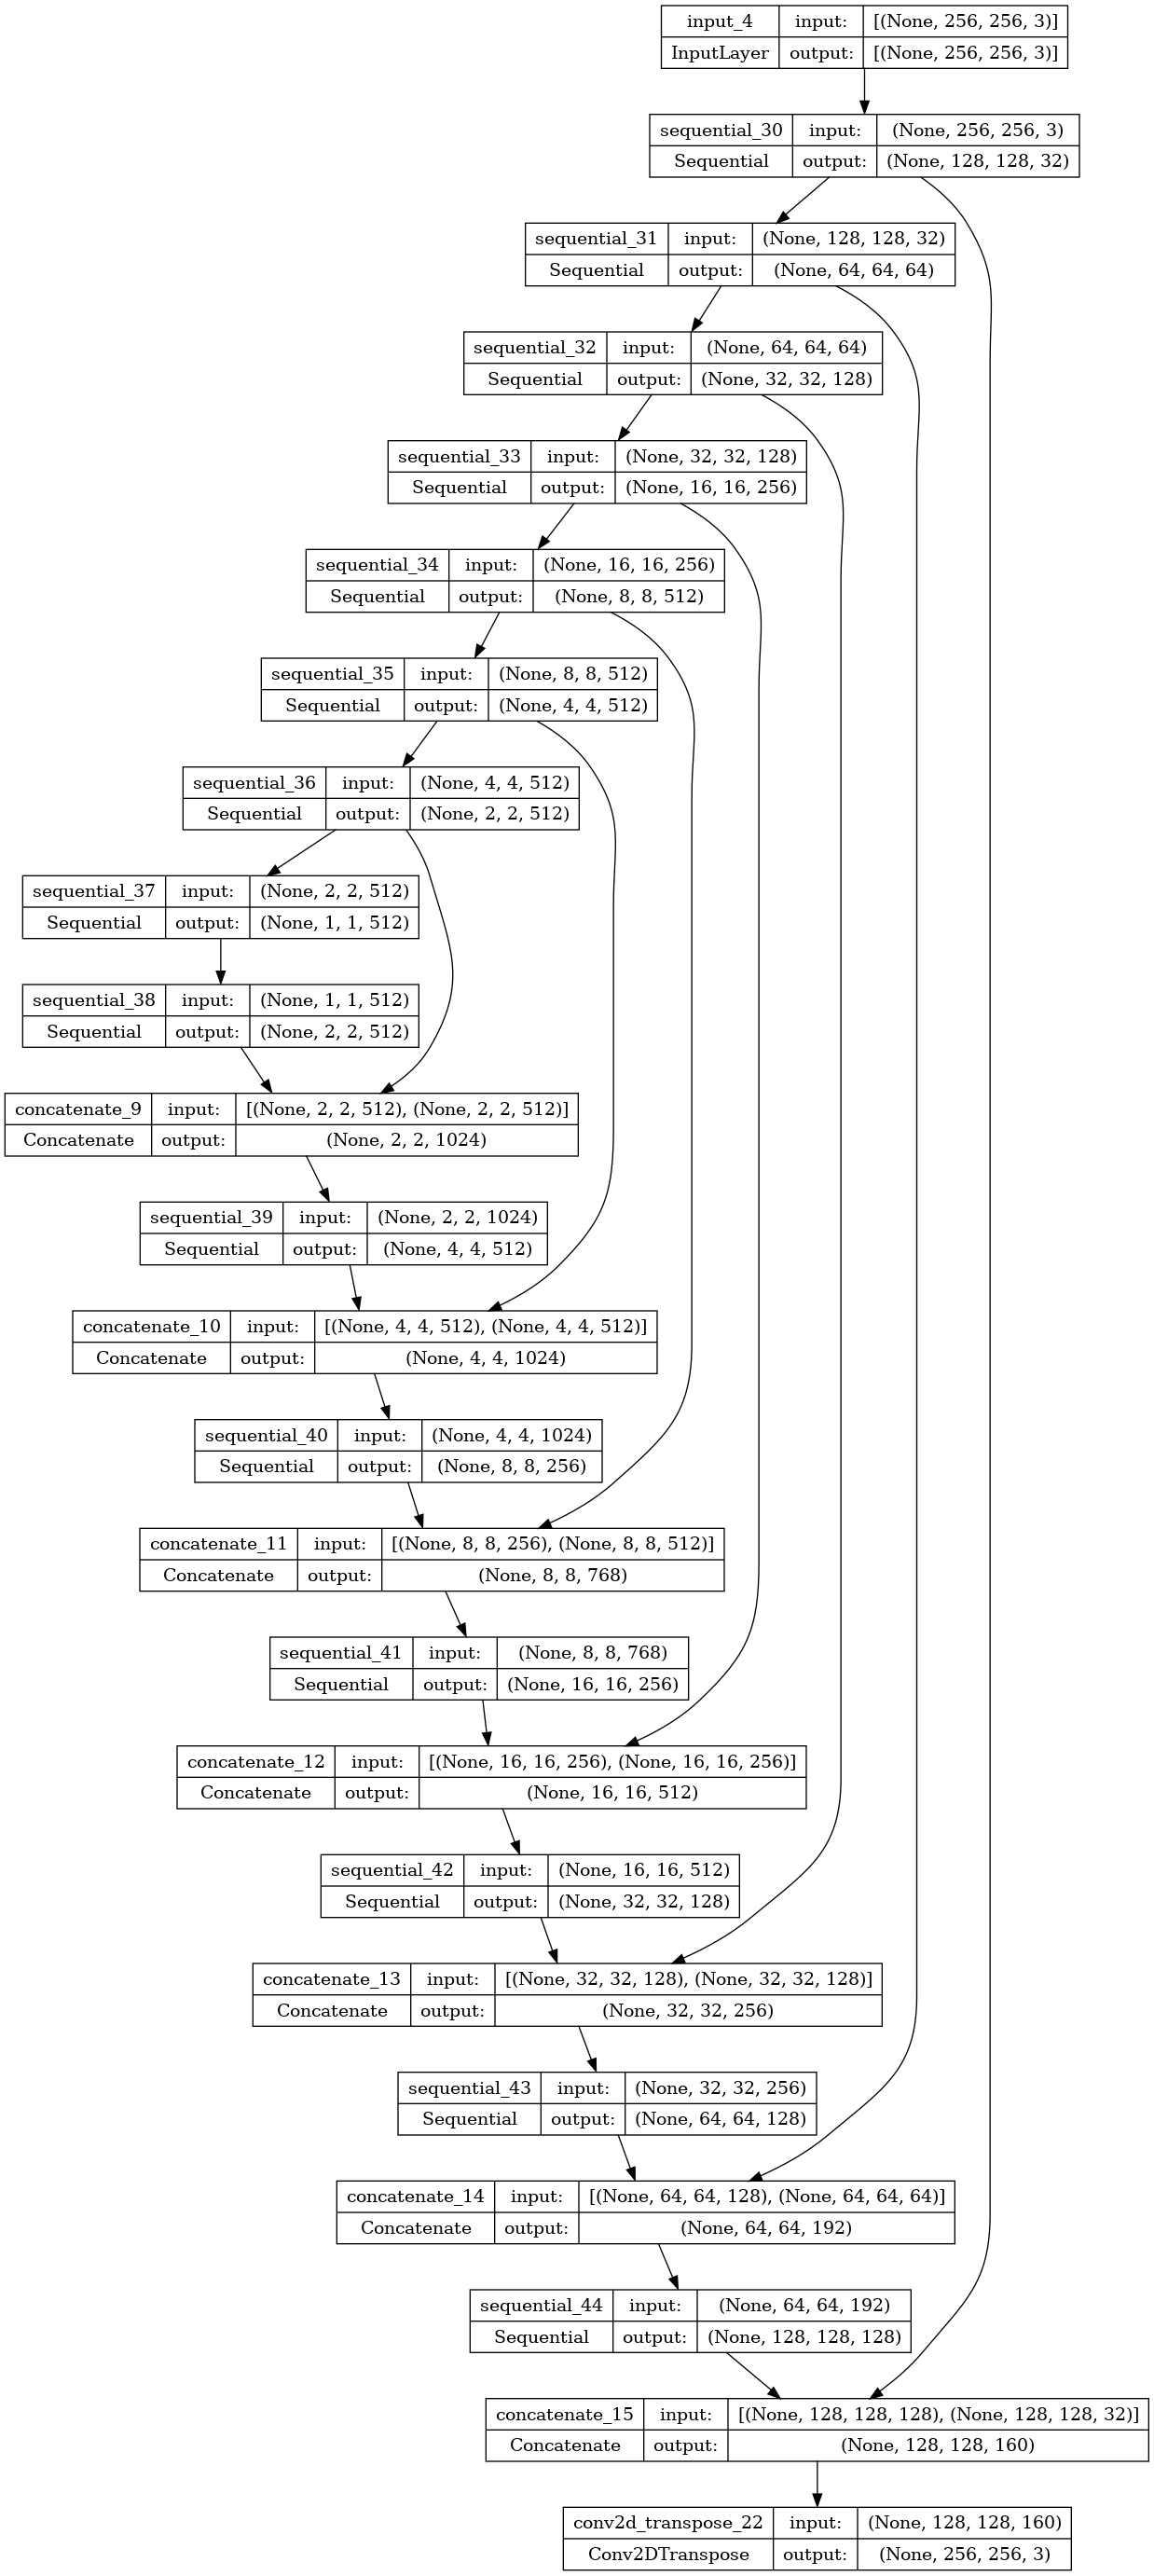

In [19]:
model = BiggerGenerator()
keras.utils.plot_model(model, show_shapes=True)

### Bigger Discriminator 
This larger discriminator has 4 downsample layers as opposed to the 2 in the simpler version. 

In [20]:
def BiggerDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(128, 4)(x) # (bs, 128, 128, 128)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(256, 8, strides=1)(down3) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

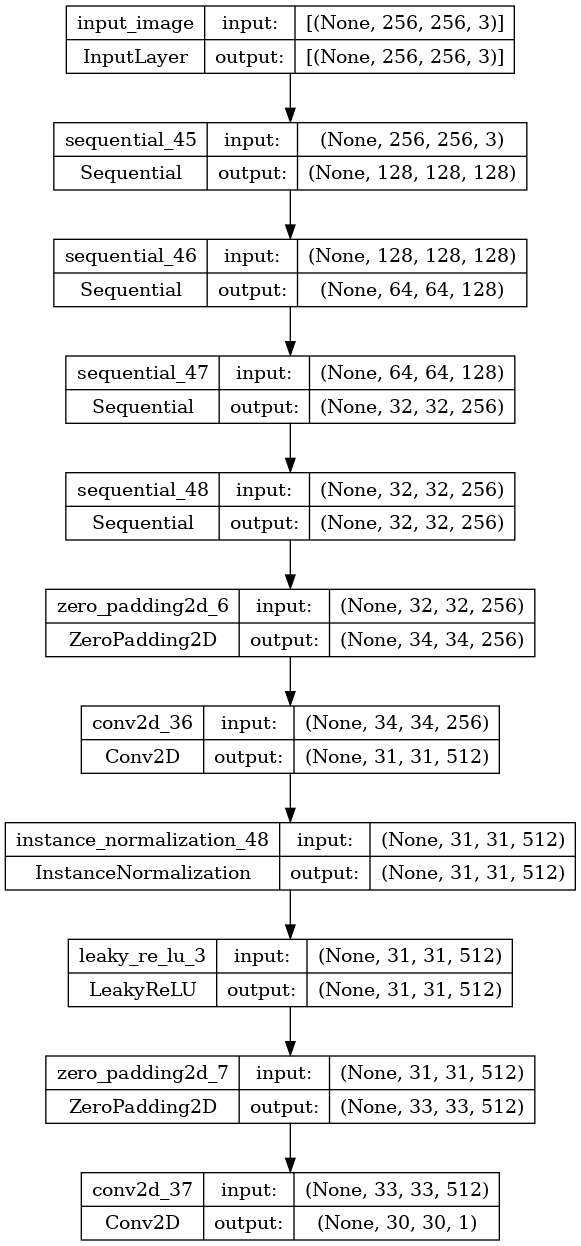

In [21]:
model = BiggerDiscriminator()
keras.utils.plot_model(model, show_shapes=True)

In [22]:
with strategy.scope():
    monet_generator_bigger = BiggerGenerator() # transforms photos to Monet-esque paintings
    photo_generator_bigger = BiggerGenerator() # transforms Monet paintings to be more like photos

    monet_discriminator_bigger = BiggerDiscriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator_bigger = BiggerDiscriminator() # differentiates real photos and generated photos

In [23]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator_bigger, photo_generator_bigger, monet_discriminator_bigger, photo_discriminator_bigger
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

### Model training
We are now ready to train our model. We will again train for 25 epochs

In [25]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 146s 247ms/step - monet_gen_loss: 6.8221 - photo_gen_loss: 6.4804 - monet_disc_loss: 0.4372 - photo_disc_loss: 0.6414
Epoch 2/25
300/300 [==============================] - 73s 245ms/step - monet_gen_loss: 4.8406 - photo_gen_loss: 5.1562 - monet_disc_loss: 0.6682 - photo_disc_loss: 0.5486
Epoch 3/25
300/300 [==============================] - 73s 245ms/step - monet_gen_loss: 4.1641 - photo_gen_loss: 4.8596 - monet_disc_loss: 0.6288 - photo_disc_loss: 0.4042
Epoch 4/25
300/300 [==============================] - 74s 245ms/step - monet_gen_loss: 4.1049 - photo_gen_loss: 3.8553 - monet_disc_loss: 0.5699 - photo_disc_loss: 0.6730
Epoch 5/25
300/300 [==============================] - 73s 245ms/step - monet_gen_loss: 4.2620 - photo_gen_loss: 4.3026 - monet_disc_loss: 0.5441 - photo_disc_loss: 0.4862
Epoch 6/25
300/300 [==============================] - 73s 245ms/step - monet_gen_loss: 4.2962 - photo_gen_loss: 5.0375 - monet_disc_loss: 0.5446

Now that are training is complete, we are ready to plot some of our predictions

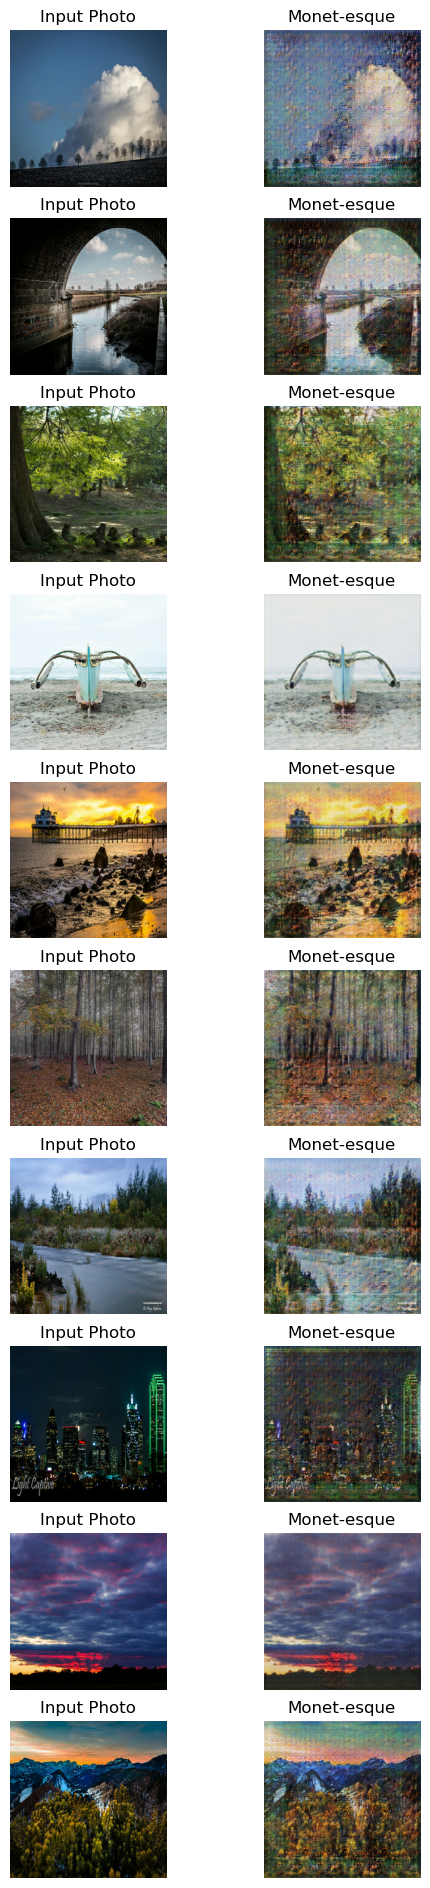

In [26]:
_, ax = plt.subplots(10, 2, figsize=(6, 24))
for i, img in enumerate(photo_dataset.take(10)):
    prediction = monet_generator_bigger(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
import tqdm
import shutil

! mkdir ../images

In [ ]:
i = 1
for img in tqdm.tqdm(photo_dataset):
    prediction = monet_generator_bigger(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Not bad! The images look a little grainy still, but they look a little more monet like then the simple version. Now I will submit on kaggle and see how the score changed. 

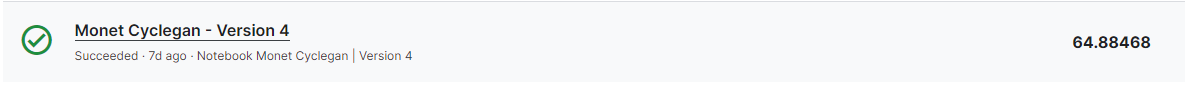

Our score improved to 64.88! This is noticeably better than the 69.33 and tells us that we are on the right track!

## Results and Analysis
The following table summarizes the results from our two experiments


| Model            | Submission Score | Avg Epoch Training Time |
|------------------|------------------|-------------------------|
| Simpler CycleGAN | 69.33            | 31 seconds              |
| Bigger CycleGAN  | 64.88            | 74 seconds              |

It is clear that our larger model performed better, however, this also came at a cost. The Avg epoch training time was more than double that of the simple model. Overall though, 74 seconds per epoch is still not too bad and I would use the larger model moving forward!


## Conclusion
This competition was a great chance for me to learn about GANs. I now feel comfortable working with complex deep learning models such as Cycle GANs. Additionally, this was a great chance to learn how to use TFRecords datasets. Also, this was great practice at understanding how layers connect inside a deep learning model. Getting the custom generator and discriminators that I designed to contain the right connections and final output shapes took a lot of trial and error, but I now have a lot better grasp on each of the components. Lastly, it is clear from my results section that the Bigger CycleGAN that I designed performed better than the smaller CycleGAN. 

There are a handful of improvements that I would love to experiment with given the time. They can be seen below:
* Experiment with different activation functions (maybe leaky ReLU?)
* Experiment with an even larger CycleGAN to see if it continues to improve. 
* Experiment with trying to create paintings in a different artist's style to. It would be cool to try to create Van Gogh style paintings to see which artist is easier to imitate!